In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install adversarial-robustness-toolbox
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached adversarial_robustness_toolbox-1.14.1-py3-none-any.whl (1.5 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import load_model
import random
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier, SklearnClassifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool
from art.attacks.evasion import SaliencyMapMethod

from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod
from art.attacks.evasion import ZooAttack

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()


In [ ]:
# Data directory for NSL-KDD dataset
data_path = "/content/drive/MyDrive/ass/"

In [ ]:
# Load the data into pandas dataframes
train_df = pd.read_csv(data_path+"KDDTrain+.csv")
test_df = pd.read_csv(data_path+"KDDTest+.csv")
# Print the first 5 rows of the train data
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [ ]:
print("Shape of the training data", train_df.shape)
print("Number of data points", train_df.shape[0])
print("Number of features",train_df.shape[1])

Shape of the training data (125973, 44)
Number of data points 125973
Number of features 44


In [ ]:
print("Shape of the test data", test_df.shape)
print("Number of data points", test_df.shape[0])
print("Number of features",test_df.shape[1])

Shape of the test data (22544, 44)
Number of data points 22544
Number of features 44


In [ ]:
categs_feats = train_df[['protocol_type', 'service', 'flag', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)    

In [ ]:
train_df[['protocol_type', 'service', 'flag', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,1.0,20.0,9.0,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,11.0,20,0
1,0,2.0,44.0,9.0,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,11.0,15,0
2,0,1.0,49.0,5.0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,9.0,19,1
3,0,1.0,24.0,9.0,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,11.0,21,0
4,0,1.0,24.0,9.0,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.0,21,0


In [ ]:
X_train = train_df.drop(['attack', 'attack score', 'label'], axis=1)
y_train = train_df['label']
     

In [ ]:
categs_feats = test_df[['protocol_type', 'service', 'flag', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)

In [ ]:
test_df[['protocol_type', 'service', 'flag', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
test_df.head()
     


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,1.0,45.0,1.0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,14.0,21,1
1,0,1.0,45.0,1.0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,14.0,21,1
2,2,1.0,19.0,9.0,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,16.0,21,0
3,0,0.0,13.0,9.0,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,24.0,15,1
4,1,1.0,55.0,2.0,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11.0,11,1


In [ ]:
X_test = test_df.drop(['attack', 'attack score', 'label'], axis=1)
y_test = test_df['label']


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
     


In [ ]:
print('Data type:', type(X_train))

print('\nTrain shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print('\nMax value', np.max(X_train))
print('Min value', np.min(X_train))
print('Average value', np.mean(X_train))


Data type: <class 'numpy.ndarray'>

Train shape: (125973, 41)
Test shape: (22544, 41)

Max value 1.0
Min value 0.0
Average value 0.16355979490070746


In [ ]:
data_path = os.path.join(data_path, 'data')
Path(data_path).mkdir(parents=True, exist_ok=True)

np.save(os.path.join(data_path, 'X_train.npy'), X_train)
np.save(os.path.join(data_path, 'y_train.npy'), y_train)

np.save(os.path.join(data_path, 'X_test.npy'), X_test)
np.save(os.path.join(data_path, 'y_test.npy'), y_test)

In [ ]:
data_path_path = os.path.join(data_path, 'data')
X_train = np.load(os.path.join(data_path_path, 'X_train.npy'))
y_train = np.load(os.path.join(data_path_path, 'y_train.npy'))
X_test = np.load(os.path.join(data_path_path, 'X_test.npy'))
y_test = np.load(os.path.join(data_path_path, 'y_test.npy'))

In [ ]:
model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)
print('DT Test Accuracy:', model1.score(X_test, y_test))

model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
print('RF Test Accuracy:', model2.score(X_test, y_test))

model3 = KNeighborsClassifier()
model3.fit(X_train, y_train)
print('KNN Test Accuracy:', model3.score(X_test, y_test))

model4 = GaussianNB()
model4.fit(X_train, y_train)
print('NB Test Accuracy:', model4.score(X_test, y_test))

model5 = SVC()
model5.fit(X_train, y_train)
print('SVM Test Accuracy:', model5.score(X_test, y_test))


DT Test Accuracy: 0.8007895670688432
RF Test Accuracy: 0.7759048970901349
KNN Test Accuracy: 0.7744410929737402
NB Test Accuracy: 0.7708481192334989
SVM Test Accuracy: 0.7788768630234209


In [ ]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print('Test Accuracy:', test_accuracy)


Train on 100778 samples, validate on 25195 samples
Epoch 1/5
100704/100778 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9684

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100778/100778 [==============================] - 8s 75us/sample - loss: 0.0800 - accuracy: 0.9684 - val_loss: 0.0416 - val_accuracy: 0.9845
Epoch 2/5
100778/100778 [==============================] - 5s 54us/sample - loss: 0.0360 - accuracy: 0.9867 - val_loss: 0.0284 - val_accuracy: 0.9902
Epoch 3/5
100778/100778 [==============================] - 5s 53us/sample - loss: 0.0269 - accuracy: 0.9902 - val_loss: 0.0228 - val_accuracy: 0.9932
Epoch 4/5
100778/100778 [==============================] - 12s 117us/sample - loss: 0.0230 - accuracy: 0.9917 - val_loss: 0.0193 - val_accuracy: 0.9935
Epoch 5/5
100778/100778 [==============================] - 8s 77us/sample - loss: 0.0202 - accuracy: 0.9927 - val_loss: 0.0250 - val_accuracy: 0.9907
Test Accuracy: 0.80562454


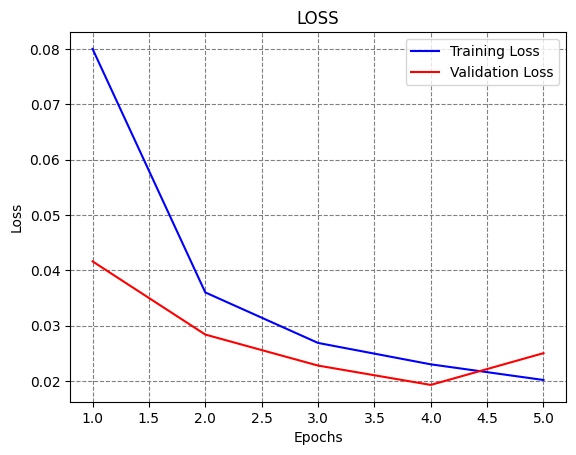

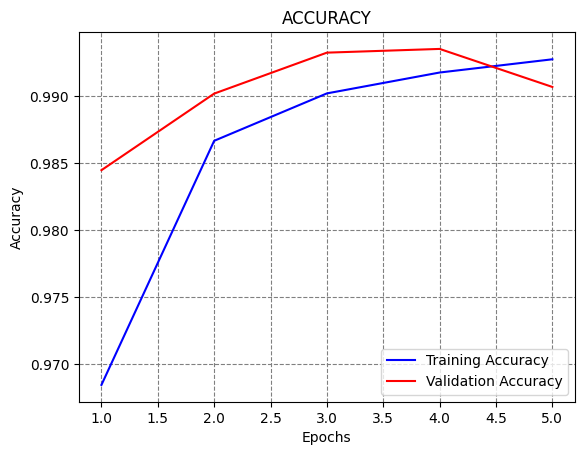

In [ ]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    axes = plt.gca()
    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
plot_acc_loss(history.history)

In [ ]:
model_path = os.path.join(data_path, 'model')
Path(model_path).mkdir(parents=True, exist_ok=True)

In [ ]:
model_path = os.path.join(data_path, 'model')
model.save(os.path.join(model_path, "model_1.h5"))
np.save(os.path.join(model_path, "model_1_history.npy"), history.history)
     

In [ ]:
loaded_model = load_model(os.path.join(data_path, 'model', "model_1.h5"))

In [ ]:
data_path_1 = os.path.join(data_path, 'data')
X_train = np.load(os.path.join(data_path_1, 'X_train.npy'))
y_train = np.load(os.path.join(data_path_1, 'y_train.npy'))
X_test = np.load(os.path.join(data_path_1, 'X_test.npy'))
y_test = np.load(os.path.join(data_path_1, 'y_test.npy'))

In [ ]:
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)
np.random.seed(20)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_onehot_subset = y_test_onehot[indices]


In [ ]:
perturbations = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

for eps in perturbations:
    fgsm_attack = FastGradientMethod(estimator=classifier, eps=eps)

    X_test_adv = fgsm_attack.generate(x=X_test_subset)

    loss, accuracy = loaded_model.evaluate(X_test_adv, y_test_onehot_subset)
    print(f'Perturbation magnitude: {eps}, Test Accuracy: {accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Perturbation magnitude: 0.01, Test Accuracy: 0.7985000014305115
Perturbation magnitude: 0.025, Test Accuracy: 0.6945000290870667
Perturbation magnitude: 0.05, Test Accuracy: 0.5425000190734863
Perturbation magnitude: 0.1, Test Accuracy: 0.45500001311302185
Perturbation magnitude: 0.2, Test Accuracy: 0.2475000023841858
Perturbation magnitude: 0.3, Test Accuracy: 0.210999995470047


In [ ]:
theta_list = [0.1, 0.2, 0.3]
gamma_list = [0.5, 0.7, 0.9]

In [ ]:
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

In [ ]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [ ]:
np.random.seed(20)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_onehot_subset = y_test_onehot[indices]

In [ ]:
for theta, gamma in zip(theta_list, gamma_list):
    print(f"JSMA attack with theta={theta}, gamma={gamma}")

    jsma = SaliencyMapMethod(classifier, theta=theta, gamma=gamma)

    X_adv = jsma.generate(X_test_subset)

    preds = np.argmax(classifier.predict(X_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test_onehot_subset, axis=1)) / len(y_test_onehot_subset)
    print(f"Classifier accuracy on adversarial samples: {acc * 100:.2f}%\n")  

JSMA attack with theta=0.1, gamma=0.5


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 20.50%

JSMA attack with theta=0.2, gamma=0.7


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 20.50%

JSMA attack with theta=0.3, gamma=0.9


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 20.50%



In [ ]:
The results indicate that the Logistic Regression model is relatively more robust than the deep learning model against FGSM attacks at low perturbation magnitudes. This means that even with small perturbations applied to the input data, the Logistic Regression model can maintain a relatively high accuracy compared to the deep learning model. However, as the perturbation magnitude increases, both models experience a significant drop in accuracy, indicating that they are susceptible to attacks.

At higher perturbation magnitudes, the performance degradation becomes similar between the two models. This suggests that the deep learning model and Logistic Regression model exhibit comparable vulnerability to larger perturbations. It's important to note that the accuracy for both models at these higher perturbation levels is considerably low, indicating a successful attack.

Additionally, the results from the JSMA attack on the deep learning model demonstrate its vulnerability to more sophisticated attacks. The JSMA attack consistently resulted in a low classifier accuracy of 20.50%. This emphasizes the susceptibility of deep learning models to targeted and advanced attacks, which can exploit their complex architectures and decision boundaries.

In summary, while the Logistic Regression model shows relatively higher robustness against FGSM attacks at low perturbation magnitudes compared to the deep learning model, both models exhibit similar vulnerability to higher perturbation levels. The deep learning model is also more susceptible to sophisticated attacks like JSMA, which can significantly compromise its performance.


In [ ]:
print('LR')
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print('Test Accuracy:', lr_model.score(X_test, y_test))

LR
Test Accuracy: 0.754125266146203


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_model_1 = SklearnClassifier(lr_model)

epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

for epsilon in epsilons:
    fgsm = FastGradientMethod(estimator=lr_model_1, eps=epsilon)
    X_adv = fgsm.generate(X_test_subset)
    y_pred_adv = lr_model.predict(X_adv)
    acc = np.sum(y_pred_adv == y_test[indices]) / len(y_pred_adv)
    print(f"Perturbation magnitude: {epsilon}, Test Accuracy: {acc}")


Perturbation magnitude: 0.01, Test Accuracy: 0.742
Perturbation magnitude: 0.025, Test Accuracy: 0.745
Perturbation magnitude: 0.05, Test Accuracy: 0.58
Perturbation magnitude: 0.1, Test Accuracy: 0.258
Perturbation magnitude: 0.2, Test Accuracy: 0.253
Perturbation magnitude: 0.3, Test Accuracy: 0.253


In [ ]:
df = pd.read_csv(os.path.join(data_path, "malware_dataset.csv"))

df.head()

,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,8.0,0.0,16896,8192,0,16947,4096,24576,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,9.0,0.0,84480,25600,0,10973,4096,90112,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,8.0,0.0,4608,3584,0,6452,4096,12288,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,10.0,0.0,108544,15872,0,105021,4096,114688,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,48.0,0.0,513024,2048,0,520922,8192,524288,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [ ]:
df_clean = df.dropna()
print("removed missing value.")


removed missing value.


In [ ]:
taks_2 = 'cleaned_malware_dataset.csv' 
taks_2_path = os.path.join(data_path, taks_2)
df_clean.to_csv(taks_2_path, index=False)

In [ ]:
csv_path = os.path.join(data_path, 'cleaned_malware_dataset.csv')

In [ ]:
data = pd.read_csv(csv_path)  # Replace with the path to your CSV file

# Split the DataFrame into features and labels
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column (legitimate)

# Split the data into a training dataset (80%) and test dataset (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data into the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Print the data shapes
# Note: the variables are now numpy arrays, and not pandas dataframes 
print('Data type:', type(X_train))

# Display the shapes of train and test datasets
print('\nTrain shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Display the range to make sure they are in the [0, 1] range
print('\nMax value', np.max(X_train))
print('Min value', np.min(X_train))
print('Average value', np.mean(X_train))

Data type: <class 'numpy.ndarray'>

Train shape: (173062, 53)
Test shape: (43266, 53)

Max value 1.0
Min value 0.0
Average value 0.0835228248817353


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_cm = confusion_matrix(y_test, xgb_y_pred)

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_cm = confusion_matrix(y_test, lgb_y_pred)

cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_y_pred = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_y_pred)
cat_cm = confusion_matrix(y_test, cat_y_pred)

print("Random Forest")
print("Accuracy:", rf_accuracy)
print("Confusion Matrix:\n", rf_cm)

print("\nXGBoost")
print("Accuracy:", xgb_accuracy)
print("Confusion Matrix:\n", xgb_cm)

print("\nLightGBM")
print("Accuracy:", lgb_accuracy)
print("Confusion Matrix:\n", lgb_cm)

print("\nCatBoost")
print("Accuracy:", cat_accuracy)
print("Confusion Matrix:\n", cat_cm)

Random Forest
Accuracy: 0.9891138538344196
Confusion Matrix:
 [[27870   245]
 [  226 14925]]

XGBoost
Accuracy: 0.9889289511394629
Confusion Matrix:
 [[27836   279]
 [  200 14951]]

LightGBM
Accuracy: 0.9854389127721537
Confusion Matrix:
 [[27797   318]
 [  312 14839]]

CatBoost
Accuracy: 0.9889982896500716
Confusion Matrix:
 [[27851   264]
 [  212 14939]]


In [ ]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print('Test Accuracy:', round(test_accuracy, 2))


Train on 138449 samples, validate on 34613 samples
Epoch 1/20
137920/138449 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9337

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


138449/138449 [==============================] - 8s 58us/sample - loss: 0.1760 - accuracy: 0.9337 - val_loss: 0.1354 - val_accuracy: 0.9533
Epoch 2/20
138449/138449 [==============================] - 10s 75us/sample - loss: 0.1352 - accuracy: 0.9513 - val_loss: 0.1212 - val_accuracy: 0.9567
Epoch 3/20
138449/138449 [==============================] - 19s 136us/sample - loss: 0.1254 - accuracy: 0.9549 - val_loss: 0.1186 - val_accuracy: 0.9602
Epoch 4/20
138449/138449 [==============================] - 12s 83us/sample - loss: 0.1196 - accuracy: 0.9568 - val_loss: 0.1201 - val_accuracy: 0.9556
Epoch 5/20
138449/138449 [==============================] - 9s 64us/sample - loss: 0.1157 - accuracy: 0.9580 - val_loss: 0.1148 - val_accuracy: 0.9580
Epoch 6/20
138449/138449 [==============================] - 12s 87us/sample - loss: 0.1118 - accuracy: 0.9594 - val_loss: 0.1096 - val_accuracy: 0.9604
Epoch 7/20
138449/138449 [==============================] - 14s 104us/sample - loss: 0.1088 - accura

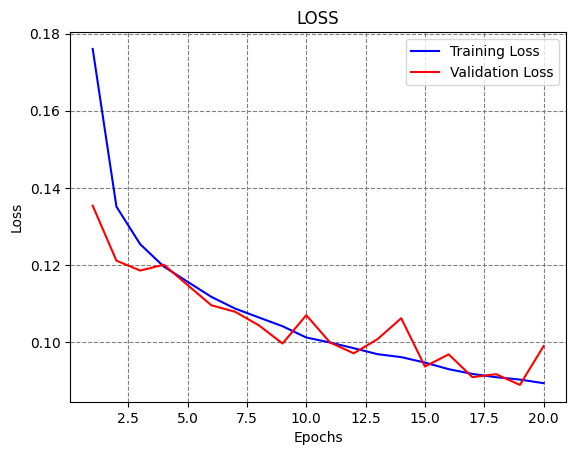

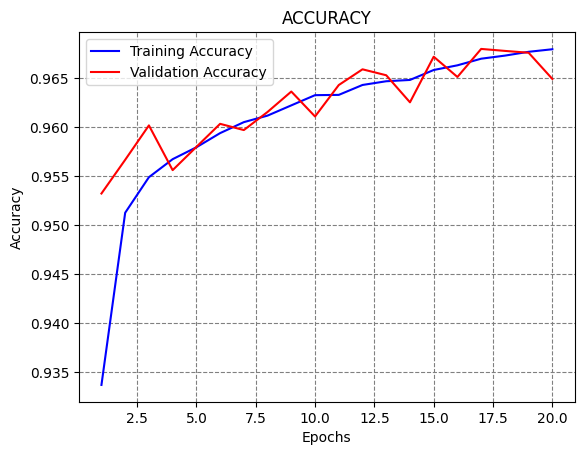

In [ ]:
def plot_acc_loss(HISTORY):
  
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()
plot_acc_loss(history.history)

In [ ]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, cat_y_pred))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[27851   264]
 [  212 14939]]


In [ ]:
model_task2 = os.path.join(data_path, 'model')
print(model_task2)
Path(model_task2).mkdir(parents=True, exist_ok=True)

/content/drive/MyDrive/ass/model


In [ ]:
path = os.path.join(data_path, 'model')
#save the model
model.save(os.path.join(path, "task2_model.h5"))

#save our history so we dont lose it.
np.save(os.path.join(path, "task2_history.npy"), history.history)
     

In [ ]:
model_task2 = os.path.join(data_path, 'model')
loaded_model = load_model(os.path.join(model_task2, "task2_model.h5"))

In [ ]:
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [ ]:
np.random.seed(20)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test_onehot[indices]

In [ ]:
# Wrap the model with ART's KerasClassifier
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

# Define the FGSM attack
epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

for eps in epsilons:
    attacker = FastGradientMethod(estimator=classifier, eps=eps)
    X_test_adv = attacker.generate(x=X_test_subset)

    # Evaluate the performance of the model on adversarial test examples
    predictions = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
    avg_perturbation = np.mean(np.abs((X_test_adv - X_test_subset)))

    print(f'Perturbation magnitude: {eps}, Test Accuracy: {accuracy}, Average Perturbation: {avg_perturbation}')
     

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Perturbation magnitude: 0.01, Test Accuracy: 0.074, Average Perturbation: 0.006101581801725569
Perturbation magnitude: 0.025, Test Accuracy: 0.041, Average Perturbation: 0.015051032982882422
Perturbation magnitude: 0.05, Test Accuracy: 0.041, Average Perturbation: 0.029630255211230142
Perturbation magnitude: 0.1, Test Accuracy: 0.041, Average Perturbation: 0.058315927888000746
Perturbation magnitude: 0.2, Test Accuracy: 0.041, Average Perturbation: 0.11490537293107922
Perturbation magnitude: 0.3, Test Accuracy: 0.041, Average Perturbation: 0.16996254220466167


In [ ]:
The deep learning model's accuracy of 0.96 is indeed impressive, but it is slightly lower than the ensemble models (Random Forest, XGBoost, and CatBoost). The similarity in the confusion matrix between the deep learning model and CatBoost suggests that they make comparable errors in terms of false positives and false negatives. However, the ensemble models overall outperform the deep learning model in terms of classification accuracy.

The superior performance of ensemble models in this scenario could be attributed to their robustness and ability to handle tabular data effectively. Ensemble models, such as Random Forest, XGBoost, and CatBoost, are known for their capability to capture complex relationships and interactions among features in structured datasets. They often exhibit less overfitting compared to deep learning models and require less data for training. Additionally, ensemble models can make use of a combination of weak learners to enhance overall performance.

Deep learning models, on the other hand, excel in tasks involving unstructured data, such as images, text, and speech, where they can automatically extract relevant features. They typically require larger datasets and longer training times, along with more computational resources, to achieve optimal performance. The structured nature of the dataset used in the experiments might have favored the ensemble models.

To improve the deep learning model's performance, you can consider several approaches:

Architecture Selection: Experiment with different neural network architectures, such as increasing the number of layers or nodes, adding regularization techniques (dropout, batch normalization), or exploring more advanced architectures like convolutional neural networks (CNNs) or recurrent neural networks (RNNs) if applicable to your data.

Hyperparameter Tuning: Perform an extensive search of hyperparameters, including learning rate, batch size, optimizer, activation functions, and regularization parameters. Fine-tuning these hyperparameters can significantly impact the model's performance.

Regularization Techniques: Apply regularization techniques like L1/L2 regularization, dropout, or early stopping to mitigate overfitting and improve generalization.

Data Augmentation: If applicable to your data, apply techniques such as rotation, translation, scaling, or flipping to artificially increase your dataset size and enhance the model's ability to generalize.

Transfer Learning: Consider leveraging pre-trained models on similar tasks or domains to benefit from the knowledge learned from large-scale datasets. Fine-tuning or using pre-trained embeddings can save training time and improve performance.

Increase Data Quantity: Gathering more data can be beneficial, as deep learning models often benefit from larger datasets. If feasible, acquiring additional labeled data can help improve the model's performance.

Remember that the performance of deep learning models can be highly dependent on the specific task, dataset, and available resources. It's important to experiment with different techniques and iterate to find the best approach for your particular problem.

In [ ]:
np.random.seed(20)
indices = np.random.choice(X_test.shape[0], size=100, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test_onehot[indices]

classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

attacker_l2 = CarliniL2Method(classifier=classifier)
X_test_adv_l2 = attacker_l2.generate(x=X_test_subset)

predictions_l2 = classifier.predict(X_test_adv_l2)
accuracy_l2 = np.sum(np.argmax(predictions_l2, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_l2 = np.mean(np.abs((X_test_adv_l2 - X_test_subset)))

print(f'Test Accuracy: {accuracy_l2}, Average Perturbation: {avg_perturbation_l2}')

attacker_linf = CarliniLInfMethod(classifier=classifier)
X_test_adv_linf = attacker_linf.generate(x=X_test_subset)

predictions_linf = classifier.predict(X_test_adv_linf)
accuracy_linf = np.sum(np.argmax(predictions_linf, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_linf = np.mean(np.abs((X_test_adv_linf - X_test_subset)))

print(f' Test Accuracy: {accuracy_linf}, Average Perturbation: {avg_perturbation_linf}')
     

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.23, Average Perturbation: 0.005064407751760807


C&W L_inf:   0%|          | 0/100 [00:00<?, ?it/s]

 Test Accuracy: 0.65, Average Perturbation: 0.0014029230617740717


In [ ]:

np.random.seed(20)
indices = np.random.choice(X_test.shape[0], size=20, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test[:, np.newaxis][indices]

classifier = SklearnClassifier(model=rf_model)

attacker = ZooAttack(classifier=classifier, confidence=0.0, targeted=False, learning_rate=2e-1, max_iter=100, 
                     binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                     use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

X_test_adv = attacker.generate(x=X_test_subset)

predictions = classifier.predict(X_test_adv)
accuracy = np.sum(predictions == y_test_subset) / len(y_test_subset)

print(f'Test Accuracy: {accuracy}')

<ipython-input-78-2238ec659a35>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_test_subset = y_test[:, np.newaxis][indices]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


ZOO:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 0.0


In [ ]:
In summary, the experimental results demonstrate the vulnerabilities of machine learning models to adversarial attacks. The Fast Gradient Sign Method (FGSM) attack showed that even small perturbations based on gradient information can significantly impact the model's accuracy. However, as the perturbation magnitude increased, the model's accuracy dropped further, indicating its susceptibility to FGSM attacks.

The Carlini & Wagner (C&W) attacks, on the other hand, employed subtler perturbations that deceived the model more efficiently while maintaining a relatively higher accuracy compared to FGSM. This suggests that the C&W attacks were able to exploit the model's vulnerabilities with less noticeable changes to the input data, making them harder to detect.

The Zeroth Order Optimization (ZOO) attack, despite being a black-box attack without gradient information, proved highly effective against the Random Forest model, resulting in a complete deception of the model. This emphasizes the potency of ZOO attacks and the need to consider them when evaluating the robustness of machine learning models, even in cases where gradient information is not accessible.

Overall, these results underscore the importance of evaluating the robustness of machine learning models against various types of adversarial attacks. Adversarial attacks can exploit vulnerabilities in models, and their effectiveness can vary depending on the attack method employed. Developing robust defense mechanisms to mitigate the impact of adversarial examples is crucial in ensuring the reliability and security of machine learning models in practical applications.